<a href="https://colab.research.google.com/github/Yogesh7920/Pascal-VOC/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing processed data from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [2]:
data_path= "/content/drive/MyDrive/cache/"

# Importing the necessary libraries

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.image import resize, ResizeMethod 

In [7]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Reading the Images and Description

In [8]:
get_resized_images = True

if get_resized_images:
    abstract_images = np.load(data_path+'abstract_images_resized.npy', allow_pickle=True)
else:
    abstract_images = np.load(data_path+'abstract_images.npy', allow_pickle=True)
abstract_images = abstract_images[:, :, :, :3]

if get_resized_images:
    pascal_images = np.load(data_path+'pascal_images_resized.npy', allow_pickle=True)
else:
    pascal_images = np.load(data_path+'pascal_images.npy', allow_pickle=True)

abstract_annots = np.load(data_path+'abstract_annots.npy', allow_pickle=True)
pascal_annots = np.load(data_path+'pascal_annots.npy', allow_pickle=True)

# abstract_annots_concat = np.load( 'abstract_annots_concat.npy', allow_pickle=True)
# pascal_annots_concat = np.load('pascal_annots_concat.npy', allow_pickle=True)


In [9]:
for i in range(len(abstract_annots)):
  abstract_annots[i].pop(0)
  for j in range(len(abstract_annots[i])):
    abstract_annots[i][j]=abstract_annots[i][j].split('\n')[0]

In [10]:
for i in range(len(pascal_annots)):
  pascal_annots[i].pop(0)
  for j in range(len(pascal_annots[i])):
    pascal_annots[i][j]=pascal_annots[i][j].split('\n')[0]

#Image Preprocessing

In [11]:
normalize=True
if normalize and np.max(abstract_images) == 255:
  abstract_images = abstract_images / 255

if normalize and np.max(pascal_images) == 255:
  pascal_images = pascal_images / 255

In [12]:
from tqdm import tqdm

In [13]:
input_shape=(224, 224, 3)

def resize_images(dataset):
    ls = []
    for img in tqdm(dataset):
        img = resize(img, size=input_shape[0:2], method=ResizeMethod.AREA)
        ls.append(img)
    return np.array(ls)

if not get_resized_images:
    pascal_images = resize_images(pascal_images)
    abstract_images = resize_images(abstract_images)
    np.save(data_path + 'abstract_images_resized.npy', abstract_images)
    np.save(data_path + 'pascal_images_resized.npy', pascal_images)

###Visualising the images along with the caption for abstract datasest

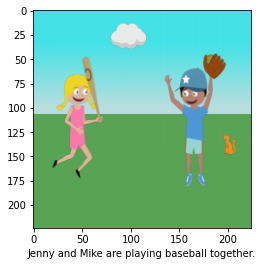

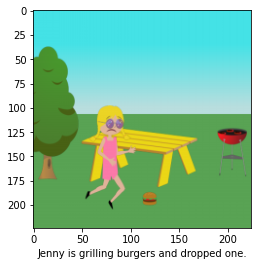

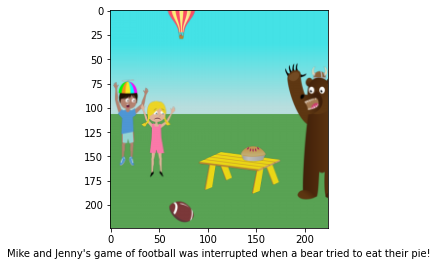

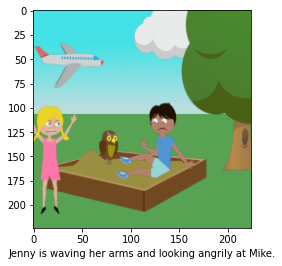

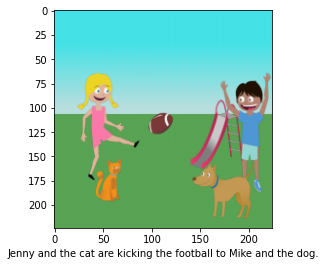

In [14]:
for i in range(5):
  plt.figure()
  plt.xlabel(abstract_annots[i][1])
  plt.imshow(abstract_images[i]/255) 

# Combining both pascal and abstract datasets

In [15]:
images = np.concatenate((abstract_images,pascal_images),axis=0)
annots = np.concatenate((abstract_annots,pascal_annots),axis=0)

In [16]:
images.shape

(1500, 224, 224, 3)

In [17]:
del pascal_images
del abstract_images

In [18]:
def preprocess_txt(text):
  txt = '<start> ' + text + ' <end>'
  txt = txt.lower()
  return txt

In [19]:
for i in range(len(annots)):
  for j in range(len(annots[i])):
    annots[i][j]=preprocess_txt(annots[i][j])

In [20]:
annots[0]

['<start> mike and jenny are playing baseball, with jenny batting and mike pitching. <end>',
 '<start> jenny and mike are playing baseball together. <end>',
 '<start> mike and jenny are playing baseball together. <end>',
 '<start> jenny just hit a home run in baseball.  her and mike jump up excitedly. <end>',
 '<start> jenny and mike are playing baseball. <end>',
 '<start> jenny and mike have fun playing baseball. <end>',
 '<start> happy jenny holds the baseball hat while happy mike holds up his hands. <end>',
 '<start> mike and jenny are playing baseball. <end>',
 '<start> mike and jenny are playing baseball while the cat watches from a distance. <end>',
 '<start> the two kids are playing baseball. <end>',
 '<start> jenny and mike are having fun playing baseball. <end>',
 '<start> mike and jenny are enjoying a game of baseball. <end>',
 '<start> jenny and mike are playing baseball <end>',
 '<start> jenny has a baseball bat and mike has a baseball glove. <end>',
 '<start> mike and jenn

# Vectorizing the images using pretrained VGG16

In [21]:
from tensorflow.keras.applications import VGG16

In [22]:
CNNmodel = VGG16(include_top=False,input_shape=(224,224,3),pooling="avg")

58892288/58889256 [==============================] - 1s 0us/step


In [23]:
CNNmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
preds=CNNmodel.predict(images)

In [25]:
image_predict_id=[]
caption_dataset=[]

for i in range(len(preds)):
  n=len(annots[i])
  image_predict_id.extend([i]*n)
  caption_dataset.extend(annots[i])


In [26]:
print(image_predict_id[1],caption_dataset[1])

0 <start> jenny and mike are playing baseball together. <end>


# Tokenizing the captions

In [27]:
top_k=2000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [28]:
tokenizer.fit_on_texts(caption_dataset)

In [29]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [30]:
train_seqs = tokenizer.texts_to_sequences(caption_dataset)

In [31]:
image_id_train, image_id_test, encoded_train, encoded_test = train_test_split(image_predict_id, train_seqs, test_size=0.2, random_state=42)

In [32]:
del image_predict_id

In [33]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [34]:
max_length = calc_max_length(train_seqs)

# Creating a generator to generate the data for the model

In [35]:
VOCAB_SIZE = top_k

In [36]:
def data_generator(descriptions, photo_id, MAX_LENGTH,VOCAB_SIZE, num_photos_per_batch):
    X, y_in, y_out = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for i in range(len(descriptions)):
            n+=1
            # retrieve the photo feature
            photo = photo_id[i]
            for j in range(1,len(descriptions[i])):
                in_seq , op_seq = descriptions[i][:j],descriptions[i][j]
                #converting input sequence to fix length
                in_seq = pad_sequences([in_seq],maxlen=MAX_LENGTH,padding="post")[0]
                # converting op_seq to vocabulary size
                op_seq = to_categorical([op_seq],num_classes=VOCAB_SIZE)[0]
                X.append(preds[photo])
                y_in.append(in_seq)
                y_out.append(op_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [np.array(X), np.array(y_in)], np.array(y_out)
                X, y_in, y_out = list(), list(), list()
                n=0

# Model

In [37]:
VOCAB_SIZE = top_k
EMBEDDING_SIZE = 128
max_len = max_length


image_descr_model = Sequential()
image_descr_model.add(Dense(EMBEDDING_SIZE, input_shape=(512,), activation='relu'))
image_descr_model.add(RepeatVector(max_len))

image_descr_model.summary()

RNNmodel = Sequential()

RNNmodel.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, input_length=max_len))
RNNmodel.add(LSTM(256, return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(EMBEDDING_SIZE)))

RNNmodel.summary()

concat_model = Concatenate()([image_descr_model.output, RNNmodel.output])
x = LSTM(128, return_sequences=True)(concat_model)
x = LSTM(512, return_sequences=False)(x)
x = Dense(VOCAB_SIZE)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_descr_model.input, RNNmodel.input], outputs = out)

# model.load_weights("/content/drive/MyDrive/datasets/model.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 49, 128)           0         
Total params: 65,664
Trainable params: 65,664
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 128)           256000    
_________________________________________________________________
lstm (LSTM)                  (None, 49, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 49, 128)           32896     
Total params: 683,136
Trainabl

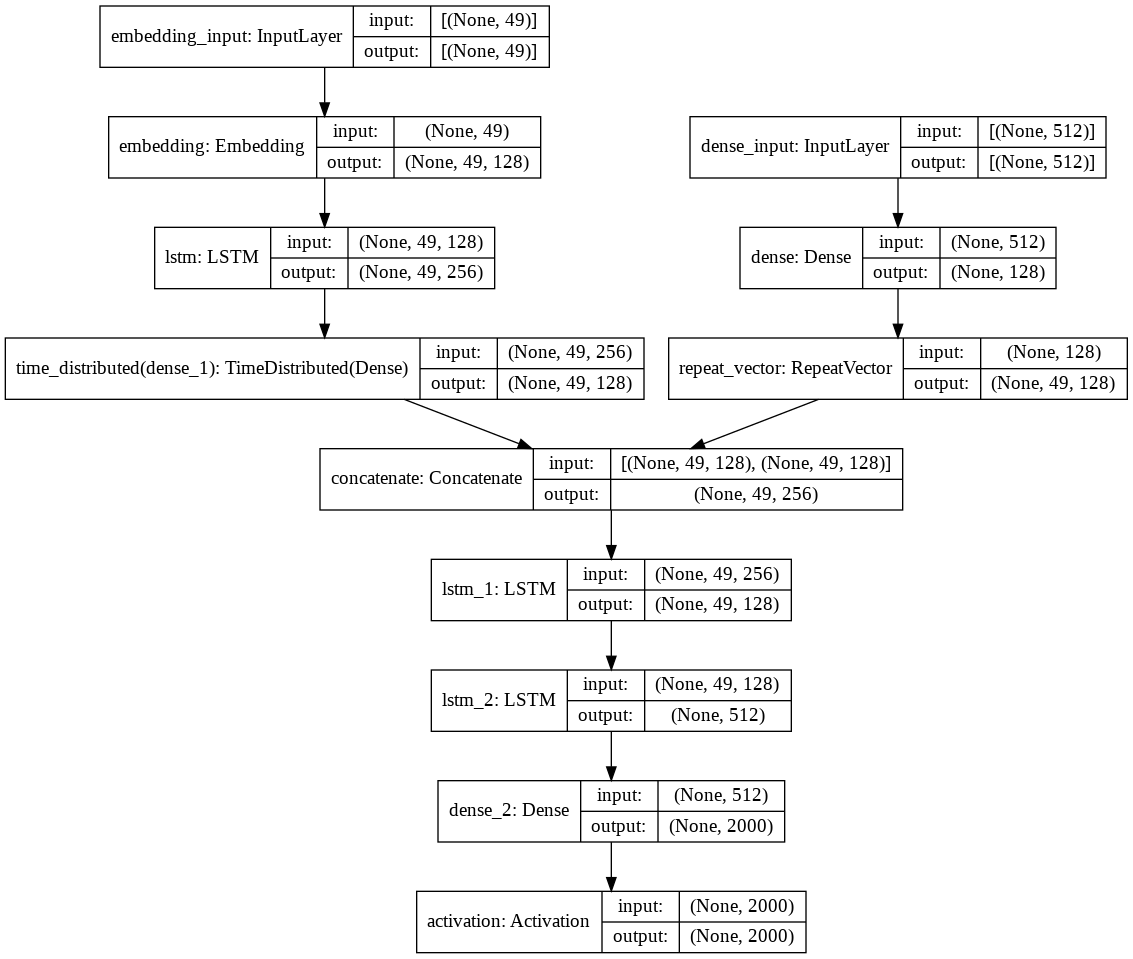

In [38]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [39]:
checkpoint_path = "/content/drive/MyDrive/datasets/model.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

### Creating the training and validation generator

In [40]:
train_generator = data_generator(encoded_train,image_id_train,max_length,VOCAB_SIZE,16)
val_generator = data_generator(encoded_test,image_id_test,max_length,VOCAB_SIZE,2)

In [41]:
# model.load_weights("/content/drive/MyDrive/datasets/model.h5")

In [42]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Training Model

In [44]:
model.fit(train_generator,steps_per_epoch=len(image_id_train) // 16,batch_size=16,epochs=50,validation_data=val_generator,validation_steps=len(image_id_test) // 16,callbacks=[cp_callback,es])

Epoch 1/50
3820/3820 [==============================] - 201s 52ms/step - loss: 4.6089 - accuracy: 0.1560 - val_loss: 3.8076 - val_accuracy: 0.2679

Epoch 00001: val_loss improved from inf to 3.80756, saving model to /content/drive/MyDrive/datasets/model.h5
Epoch 2/50
3820/3820 [==============================] - 197s 51ms/step - loss: 3.6734 - accuracy: 0.2952 - val_loss: 3.2860 - val_accuracy: 0.3571

Epoch 00002: val_loss improved from 3.80756 to 3.28598, saving model to /content/drive/MyDrive/datasets/model.h5
Epoch 3/50
3820/3820 [==============================] - 196s 51ms/step - loss: 3.2199 - accuracy: 0.3661 - val_loss: 3.1261 - val_accuracy: 0.3904

Epoch 00003: val_loss improved from 3.28598 to 3.12614, saving model to /content/drive/MyDrive/datasets/model.h5
Epoch 4/50
3820/3820 [==============================] - 196s 51ms/step - loss: 3.0141 - accuracy: 0.3999 - val_loss: 2.9399 - val_accuracy: 0.4215

Epoch 00004: val_loss improved from 3.12614 to 2.93992, saving model to /

In [ ]:
def getImage(x):
    
    test_img_path = abstract_images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (299,299))

    test_img = np.reshape(test_img, (1,299,299,3))
    
    return test_img

In [48]:
preds[0].shape

(512,)

In [58]:
inp,out = next(train_generator)

In [59]:
inp[0].shape

(175, 512)

In [60]:
inp[1].shape

(175, 49)

881
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
588
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
841
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


926
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
641
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
241
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
1287
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


845
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
1274
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
827
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)
(1, 512) (1, 49, 1)


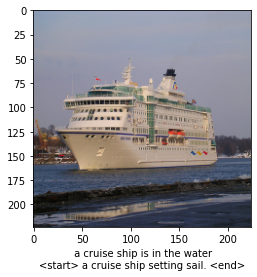

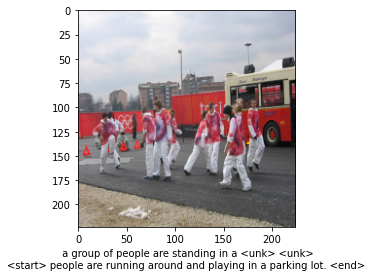

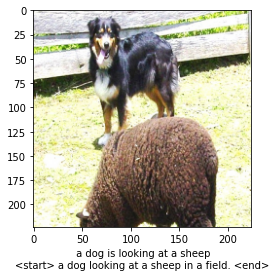

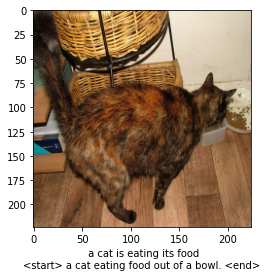

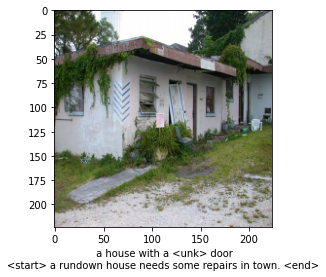

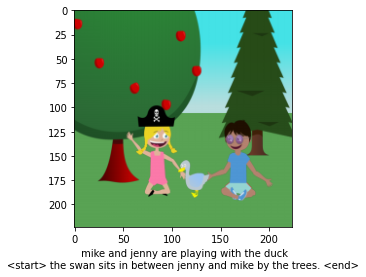

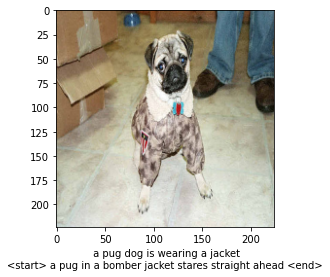

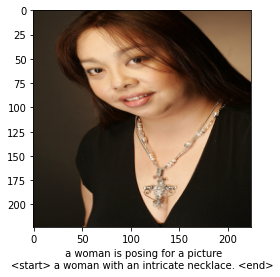

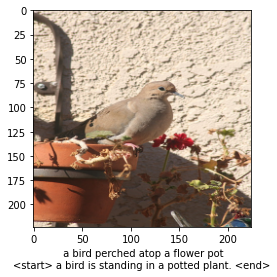

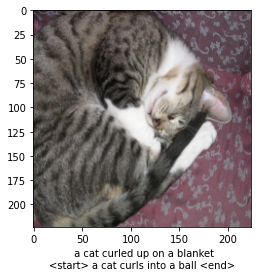

In [65]:
for i in range(10):
    
    id = np.random.randint(0,1500)
    print(id)
    test_feature = preds[id].reshape(1,512)
    
    
    text_inp = ['<start>']

    count = 0
    caption = ''
    while count < max_length:
        count += 1
        encoded = tokenizer.texts_to_sequences(text_inp)
        encoded = pad_sequences([encoded],maxlen=max_length,padding="post")
        print(test_feature.shape,encoded.shape)
        prediction = np.argmax(model.predict([test_feature, encoded]))
        sampled_word = tokenizer.index_word[prediction]
        if sampled_word == '<end>':
            break

        caption = caption + ' ' + sampled_word
        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(images[id] /255)
    plt.xlabel(caption+'\n'+annots[id][0])

In [ ]:
model.save('m')